In [1]:
%matplotlib inline

import sys

import matplotlib.pyplot as plt

import os

import matplotlib as mpl

import numpy as np

from PIL import Image

from pyquaternion import Quaternion

In [2]:
sys.path.append("/home/nils/data_fusion/nuscenes-devkit/python-sdk")

In [3]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


In [4]:
from nuscenes.utils.data_classes import LidarPointCloud

from nuscenes.utils.geometry_utils import view_points


# Task 1

## Picking a random sample

In [5]:
my_sample = nusc.sample[10]

my_scene_token =my_sample['scene_token']

my_scene = nusc.get('scene', my_scene_token)

In [6]:
first_sample_token = my_scene['first_sample_token']

first_sample_from_scene = nusc.get('sample', first_sample_token)

## Picking the van in front by hand

In [7]:
vehicle_annotation_tokens = []
for i in range(len(first_sample_from_scene['anns'])):
    first_annotation_token_of_first_sample = first_sample_from_scene['anns'][i]
    if nusc.get('sample_annotation', first_annotation_token_of_first_sample)['category_name'] == 'vehicle.car':
        vehicle_annotation_tokens.append(first_annotation_token_of_first_sample)

# annotation of first frame
van_annotation_token = vehicle_annotation_tokens[7]

In [8]:
def get_lidar_pointcloud(sample_token):
    sample_record = nusc.get('sample', sample_token)
    pointsensor_channel = 'LIDAR_TOP'
    pointsensor_token = sample_record['data'][pointsensor_channel]
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = nusc.get('sample_data', pointsensor_token)['filename']
    pc =LidarPointCloud.from_file(os.path.join('nuscenes',pcl_path))
    return pointsensor_token, pc.points

In [9]:
def rotate_pointcloud(cloud, quaternion):
    def rot(an_array):
        return quaternion.rotate(an_array)
    return np.array(list(map(rot, cloud)))

In [10]:
def visualize_absolute(ax, absolute_points, ego_pose, van_translation, relativeboxvectors):
    #plt.axis('equal')
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([ymin,ymax])
    #ax.set(xlim=(300, 500), ylim=(1100, 1300))
    return ax.scatter(absolute_points[0], absolute_points[1], c='red', s=0.3), ax.scatter(ego_pose['translation'][0], ego_pose['translation'][1]),ax.plot([van_translation[0] + relativeboxvector[0] for relativeboxvector in relativeboxvectors], [van_translation[1] + relativeboxvector[1] for relativeboxvector in relativeboxvectors])[0]

In [11]:
def create_bounding_box(annotation_token):
    '''
    creates bounding box used for plotting
    '''
    van_annotation = nusc.get('sample_annotation', annotation_token)
    relativeboxvectors = [(van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0)]
    return np.array(relativeboxvectors), van_annotation['translation']

In [12]:
#create list of annotation tokens
current_van_annotation_token = van_annotation_token
annotation_tokens = []
while current_van_annotation_token != '':
    annotation_tokens.append(current_van_annotation_token)
    #next annotaton token
    current_van_annotation_token = nusc.get('sample_annotation', current_van_annotation_token)['next']

## Create Video

In [13]:
# same as last time. Now we just rotate back.

(393.6603981850444, 432.9854006128025, 1099.0106057555454, 1184.7894160060794)

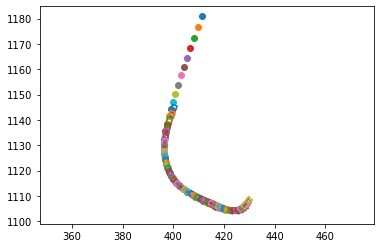

In [14]:
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)  # fig and axes created once
frontimages = []
raw_measurements = []
timestamps = []
annotated_positions = []
# Display points and bounding box in global coordinates over whole scene
for i,current_van_annotation_token in enumerate(annotation_tokens):

    # filter out points outside bounding box


    ## Grab the data

    van_annotation = nusc.get('sample_annotation', current_van_annotation_token)

    #get respective frame token
    sample_token = van_annotation['sample_token']

    timestamps.append(nusc.get('sample', sample_token)['timestamp'])


    pointsensor_token, points = get_lidar_pointcloud(sample_token)
    calibrated_sensor_token = nusc.get('sample_data', pointsensor_token)['calibrated_sensor_token']
    calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
    ego_pose = nusc.get('ego_pose', nusc.get('sample_data', pointsensor_token)['ego_pose_token'])

    ## translate points to global reference frame

    ### Rotate points around sensor and ego rotation

    pointsensor_quaternion = Quaternion(calibrated_sensor['rotation'])
    ego_quaternion = Quaternion(ego_pose['rotation'])

    sensor_rotated_points = np.dot(pointsensor_quaternion.rotation_matrix, points[:3,:])
    rotated_points = np.dot(ego_quaternion.rotation_matrix, sensor_rotated_points)

    # use broadcasting to add translation to x and y dimension
    absolute_points = rotated_points+np.array(ego_pose['translation'][:3]).reshape(-1,1)


    ### rotate points by inverse bounding box rotation (translation to its reference frame unnecessary for only filtering)
    reverse_van_quaternion = Quaternion(w=-1*van_annotation['rotation'][0], x=van_annotation['rotation'][1], y=van_annotation['rotation'][2], z=van_annotation['rotation'][3])
    points_bounding_rotation = np.dot(reverse_van_quaternion.rotation_matrix, absolute_points)

    #new stuff
    relativeboxvectors, position = create_bounding_box(current_van_annotation_token)

    annotated_positions.append(position)
    rotated_box = relativeboxvectors+reverse_van_quaternion.rotate(position)

    x_max = rotated_box[:,0].max()
    x_min = rotated_box[:,0].min()

    y_max = rotated_box[:,1].max()
    y_min = rotated_box[:,1].min()

    ## Remove points that are outside the bounding box
    mask = np.ones(points_bounding_rotation.shape[1], dtype=bool)

    mask = np.logical_and(mask, points_bounding_rotation[0] > x_min)
    mask = np.logical_and(mask, points_bounding_rotation[0] < x_max)

    mask = np.logical_and(mask, points_bounding_rotation[1] > y_min)
    mask = np.logical_and(mask, points_bounding_rotation[1] < y_max)

    points_filtered_rotated = points_bounding_rotation[:,mask]

    ### rotate points back

    van_quaternion = Quaternion(van_annotation['rotation'])
    points_filtered_absolute = np.dot(van_quaternion.rotation_matrix, points_filtered_rotated)
    # append list of plots to movie
    rotated_relativeboxvectors = rotate_pointcloud(relativeboxvectors, van_quaternion)
    plotlist = visualize_absolute(ax, points_filtered_absolute, ego_pose, van_annotation['translation'], rotated_relativeboxvectors)
    raw_measurements.append(points_filtered_absolute)
    ims.append(plotlist)     

ax.axis('equal')


## Create Movie

In [15]:
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('filtered_im.gif', writer='pillow')

# Task 2

In [16]:
def prediction_step(state_vector, covariance_matrix, sigma_v, t):
    F = np.array(((1,0,t,0),(0,1,0,t),(0,0,1,0),(0,0,0,1)))
    transition_error = np.array((0.5*t**2, 0.5*t**2, t, t))
    Q = sigma_v**2*np.dot(transition_error.reshape(-1,1),transition_error.reshape(-1,1).T)
    
    state_vector_next = np.dot(F, state_vector)
    C_next = np.dot(np.dot(F, covariance_matrix), F.T) + Q
    return state_vector_next, C_next

## b)

In [17]:
def measuring_step(state_vector, C, measurement, R):
    H = np.array(((1, 0, 0, 0), (0,1,0,0)))
    S = np.dot(np.dot(H,C), H.T) + R
    K = np.dot(np.dot(C, H.T), np.linalg.inv(S))
    C_next = C - np.dot(np.dot(K, S),K.T)
    state_vector_next = state_vector + np.dot(K,np.array(measurement) - np.dot(H, state_vector))
    return state_vector_next, C_next

## c)

In [18]:
measurements = []
t_last = timestamps[0]
for r, t in zip(raw_measurements, timestamps):
    x_mean = r[0].mean()
    y_mean = r[1].mean()
    measurements.append((x_mean, y_mean, (t-t_last)/1000000))
    t_last = t
# throw first 11 away because some are empty
cleaned_measurements = measurements[11:]

/home/nils/anaconda3/envs/datafusion/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/home/nils/anaconda3/envs/datafusion/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nils/anaconda3/envs/datafusion/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice.


In [42]:
cleaned_measurements

[(397.9799414014502, 1121.3696933701106, 0.49932),
 (398.1822837697118, 1121.5996405586416, 0.499858),
 (400.1408743754392, 1118.2281596475632, 0.499889),
 (399.7442237465409, 1117.4150647485553, 0.550204),
 (400.6855546645507, 1116.6985981805838, 0.500986),
 (401.59406411675064, 1115.2073550887173, 0.500404),
 (402.68479864748286, 1113.6170150574355, 0.501017),
 (404.29664683725724, 1113.2180530143653, 0.500397),
 (405.7249703594426, 1111.9087418495185, 0.499323),
 (406.9933407701191, 1111.0609878617527, 0.499318),
 (408.1853300917355, 1110.7266699578513, 0.499897),
 (409.4179944759696, 1109.509356813025, 0.449547),
 (410.8933534334881, 1109.020227845097, 0.49989),
 (411.9681381128321, 1108.4380200144597, 0.550177),
 (413.20814758697486, 1107.9015428970408, 0.500447),
 (414.79636265043564, 1107.1850105566423, 0.599385),
 (416.37414193208485, 1106.5156059247201, 0.499875),
 (417.98792858036757, 1105.828671554556, 0.500435),
 (420.03777227254824, 1105.215275256057, 0.39981),
 (419.76491

In [19]:
def run_filter(C,sigma_v,R):
    initial_position = np.array(cleaned_measurements[1][:2])
    initial_velocity = (np.array(cleaned_measurements[1][:2]) - np.array(cleaned_measurements[0][:2]))/cleaned_measurements[0][2]
    state_vector = np.append(initial_position,initial_velocity)

    estimated_positions = []
    for i,m in enumerate(cleaned_measurements):
        state_vector, C = prediction_step(state_vector, C, sigma_v, t = m[2])
        estimated_positions.append(state_vector)
        state_vector, C = measuring_step(state_vector, C, m[:2], R)
    return estimated_positions


In [33]:
def squared_distance(v1, v2):
    assert len(v1) == len(v2), "vectors have different lengths"
    summe = 0
    for i in range(len(v1)):
        summe += np.sqrt((v1[i][0]-v2[i][0])**2 + (v1[i][1]-v2[i][1])**2)
    return summe/len(v1)

error:1.7617097043356336


(396.3536528750957, 432.13200045489583, 1101.0113836873554, 1122.8209307976401)

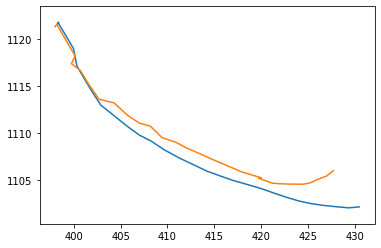

In [52]:
C = 1*np.eye(4)
sigma_v= 0.1
r = 0.5
R = np.array(((r,0),(0,r)))

estimated_positions = run_filter(C,sigma_v,R)

print(f'error:{squared_distance(estimated_positions, cleaned_measurements)}')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot([pos[0] for pos in estimated_positions], [pos[1] for pos in estimated_positions])
plt.plot([pos[0] for pos in cleaned_measurements], [pos[1] for pos in cleaned_measurements])
ax.axis('equal')